# Lag time in river contribution

- Fig --- time series of riverine transport across boundaries 
- Fig --- lag time at Baffin Bay
- Fig --- lag time at Nares Strait

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from dateutil.relativedelta import relativedelta
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import netCDF4 as nc
from itertools import compress
import datetime as dt
from scipy.signal import find_peaks
import seaborn as sns; sns.set()
from matplotlib.ticker import FormatStrFormatter
import os
from datetime import date
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

##### Parameters:

In [2]:
# Domain dimensions:
imin, imax = 1480, 2180
jmin, jmax = 160, 800

# Results folders:

folder_riv2a = '/ocean/brogalla/GEOTRACES/time-series/riv-2a-202005/'
folder_riv2b = '/ocean/brogalla/GEOTRACES/time-series/riv-2b-202005/'
folder_ref   = '/ocean/brogalla/GEOTRACES/time-series/Mn-set4-202004//'

# Boundary coordinates:
l1i = 2013-imin;                      l1j = np.arange(300-jmin,392-jmin)
l2i = 1935-imin;                      l2j = np.arange(450-jmin,530-jmin)
l3i = np.arange(1850-imin,1885-imin); l3j = 555-jmin
l4i = np.arange(1753-imin,1837-imin); l4j = 568-jmin
l5i = np.arange(1720-imin,1790-imin); l5j = 605-jmin
l6i = 1730-imin;                      l6j = np.arange(660-jmin,690-jmin)
t1i = np.arange(1635-imin,1653-imin); t1j = 760-jmin
r1i = 1520-imin;                      r1j = np.arange(505-jmin,673-jmin)
r2i = 1520-imin;                      r2j = np.arange(385-jmin,405-jmin)
N1i = np.arange(1570-imin,1630-imin); N1j = 635-jmin #Nares
P1i = 1585-imin;                      P1j = np.arange(485-jmin,538-jmin)  #Parry channel

##### Load files:

In [3]:
mask  = nc.Dataset('/ocean/brogalla/GEOTRACES/ariane_runs/ANHA12_Ariane_mesh.nc')
tmask = np.array(mask.variables['tmask'])
land_mask = np.ma.masked_where((tmask[0,:,:,:] > 0.1) , tmask[0,:,:,:])

mesh  = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12-EXH006_5d_gridT_y2002m01d05.nc')
lons  = np.array(mesh.variables['nav_lon'])
lats  = np.array(mesh.variables['nav_lat'])
tmask = tmask[0,:,imin:imax,jmin:jmax]

In [4]:
ref   = nc.Dataset('/data/brogalla/run_storage/Mn-set4-202004/ref-2003/ANHA12_EXH006_2003_monthly.nc',  'r')
tlons = np.array(ref.variables['nav_lon'])
tlats = np.array(ref.variables['nav_lat'])
depth = np.array(ref.variables['deptht'])

In [5]:
rf = np.empty((19*12, imax-imin, jmax-jmin))
i  = 0
for year in range(2002, 2020):
# for year in range(2002, 2005):
    for month in range(0,12):
        c = nc.Dataset('/data/brogalla/runoff/ANHA12_runoff_monthly_combined_Dai_Trenberth_Bamber_y'+str(year)+'.nc','r')
        rf[i*12+month,:,:] = np.array(c.variables['runoff'])[month,imin:imax,jmin:jmax]
        
    i+=1

In [6]:
rclass = nc.Dataset('/ocean/brogalla/GEOTRACES/data/river_class-202005.nc','r')
river_class = rclass.variables['rclass']
river_class = np.array(river_class)

##### Functions:

In [7]:
def time_series_pickle(year, riv_2a=False, riv_2b=False):
    
    # Load calculated time series of fluxes:
    if riv_2a:
        time_series_V1, time_series_V2, time_series_V3, time_series_V4, time_series_V5, time_series_V6,time_series_V7,\
        time_series_V8, time_series_V9, time_series_V10, time_series_V11, time_series_mn1, time_series_mn2, \
        time_series_mn3, time_series_mn4, time_series_mn5, time_series_mn6, time_series_mn7, time_series_mn8, \
        time_series_mn9, time_series_mn10, time_series_mn11 =  \
                            pickle.load(open(folder_riv2a+'time-series-'+str(year)+'.pickle','rb'))  
    elif riv_2b:
        time_series_V1, time_series_V2, time_series_V3, time_series_V4, time_series_V5, time_series_V6,time_series_V7,\
        time_series_V8, time_series_V9, time_series_V10, time_series_V11, time_series_mn1, time_series_mn2, \
        time_series_mn3, time_series_mn4, time_series_mn5, time_series_mn6, time_series_mn7, time_series_mn8, \
        time_series_mn9, time_series_mn10, time_series_mn11 =  \
                            pickle.load(open(folder_riv2b+'time-series-'+str(year)+'.pickle','rb'))  
    else:
        time_series_V1, time_series_V2, time_series_V3, time_series_V4, time_series_V5, time_series_V6,time_series_V7,\
        time_series_V8, time_series_V9, time_series_V10, time_series_V11, time_series_mn1, time_series_mn2, \
        time_series_mn3, time_series_mn4, time_series_mn5, time_series_mn6, time_series_mn7, time_series_mn8, \
        time_series_mn9, time_series_mn10, time_series_mn11 =  \
                            pickle.load(open(folder_ref+'time-series-'+str(year)+'.pickle','rb'))
    
    # Conservation of volume check:
    sum_V = -1*np.sum(time_series_V1,axis=2) - np.sum(time_series_V2,axis=2) - np.sum(time_series_V7,axis=2) - \
           (np.sum(time_series_V3,axis=2) + np.sum(time_series_V4,axis=2) + np.sum(time_series_V5,axis=2) + \
            np.sum(time_series_V6,axis=2)) + np.sum(time_series_V8,axis=2) + np.sum(time_series_V9,axis=2)
#     print('Total volume change at end of time period: ', np.sum(sum_V))
    
    # Combine western CAA time series:
    time_series_mn_WCAA = np.sum(np.sum(time_series_mn3,axis=2),axis=1) + \
                    np.sum(np.sum(time_series_mn4,axis=2),axis=1) + \
                    np.sum(np.sum(time_series_mn5,axis=2),axis=1) + \
                    np.sum(np.sum(time_series_mn6,axis=2),axis=1)
    time_series_V_WCAA = np.sum(np.sum(time_series_V3,axis=2),axis=1) + \
                    np.sum(np.sum(time_series_V4,axis=2),axis=1) + \
                    np.sum(np.sum(time_series_V5,axis=2),axis=1) + \
                    np.sum(np.sum(time_series_V6,axis=2),axis=1)
    
    return time_series_mn1, time_series_mn2, time_series_mn_WCAA, time_series_mn7, time_series_mn8, \
            time_series_mn9, time_series_mn10, time_series_mn11

In [8]:
def file_dates(year):
    #start_date and end_date are datetime objects
    start_date = dt.datetime(year,1,1)
    end_date   = dt.datetime(year,12,31)
    
    file_list1E = np.sort(os.listdir('/data/brogalla/run_storage/Mn-set4-202004/ref-'+str(year)+'/'))
    file_list2 = np.sort(os.listdir('/data/brogalla/ANHA12/'))
    
    Vlist = [i[26:31]=='gridV' for i in file_list2]
    gridV_list = list(compress(file_list2, Vlist))
    dateV_list = [dt.datetime.strptime(i[14:25], "y%Ym%md%d") for i in gridV_list]
    gridV_file_list = list(compress(gridV_list, [V > start_date and V < end_date for V in dateV_list]))
    
    dates = [dt.datetime.strptime(i[14:25], "y%Ym%md%d") for i in gridV_file_list]
    
    return dates

In [9]:
def flux_layer(top, bottom):
    in_BB_ref   = np.empty((18, 72)); out_BB_ref  = np.empty((18, 72));
    in_N1_ref   = np.empty((18, 72)); out_N1_ref  = np.empty((18, 72));
    in_PC1_ref  = np.empty((18, 72)); out_PC1_ref = np.empty((18, 72));
    
    in_BB_riv2a   = np.empty((18, 72)); out_BB_riv2a  = np.empty((18, 72));
    in_N1_riv2a   = np.empty((18, 72)); out_N1_riv2a  = np.empty((18, 72));
    in_PC1_riv2a  = np.empty((18, 72)); out_PC1_riv2a = np.empty((18, 72));
    
    in_BB_riv2b   = np.empty((18, 72)); out_BB_riv2b  = np.empty((18, 72));
    in_N1_riv2b   = np.empty((18, 72)); out_N1_riv2b  = np.empty((18, 72));
    in_PC1_riv2b  = np.empty((18, 72)); out_PC1_riv2b = np.empty((18, 72));

    count = 0
    for year in range(2002, 2020):
        ts_year_mn1, ts_year_mn2, ts_year_mn_WCAA, ts_year_mn7, ts_year_mn8, ts_year_mn9, \
        ts_year_mn10, ts_year_mn11       = time_series_pickle(year)
        riv2a_year_mn1, riv2a_year_mn2, riv2a_year_mn_WCAA, riv2a_year_mn7, riv2a_year_mn8, riv2a_year_mn9, \
        riv2a_year_mn10, riv2a_year_mn11 = time_series_pickle(year, riv_2a=True)
        riv2b_year_mn1, riv2b_year_mn2, riv2b_year_mn_WCAA, riv2b_year_mn7, riv2b_year_mn8, riv2b_year_mn9, \
        riv2b_year_mn10, riv2b_year_mn11 = time_series_pickle(year, riv_2b=True)

        for date in range(0,72):
            in_BB_ref[count,date]     = -np.sum(ts_year_mn8[date, top:bottom, :][ts_year_mn8[date, top:bottom, :] >= 0])
            out_BB_ref[count,date]    = -np.sum(ts_year_mn8[date, top:bottom, :][ts_year_mn8[date, top:bottom, :] < 0])
            in_BB_riv2a[count,date]   = -np.sum(riv2a_year_mn8[date, top:bottom, :][riv2a_year_mn8[date, top:bottom, :] >= 0])
            out_BB_riv2a[count,date]  = -np.sum(riv2a_year_mn8[date, top:bottom, :][riv2a_year_mn8[date, top:bottom, :] < 0])
            in_BB_riv2b[count,date]   = -np.sum(riv2b_year_mn8[date, top:bottom, :][riv2b_year_mn8[date, top:bottom, :] >= 0])
            out_BB_riv2b[count,date]  = -np.sum(riv2b_year_mn8[date, top:bottom, :][riv2b_year_mn8[date, top:bottom, :] < 0])
            
            in_N1_ref[count,date]     = -np.sum(ts_year_mn10[date, top:bottom, :][ts_year_mn10[date, top:bottom, :] >= 0])
            out_N1_ref[count,date]    = -np.sum(ts_year_mn10[date, top:bottom, :][ts_year_mn10[date, top:bottom, :] < 0]) 
            in_N1_riv2a[count,date]   = -np.sum(riv2a_year_mn10[date, top:bottom, :][riv2a_year_mn10[date, top:bottom, :] >= 0])
            out_N1_riv2a[count,date]  = -np.sum(riv2a_year_mn10[date, top:bottom, :][riv2a_year_mn10[date, top:bottom, :] < 0]) 
            in_N1_riv2b[count,date]   = -np.sum(riv2b_year_mn10[date, top:bottom, :][riv2a_year_mn10[date, top:bottom, :] >= 0])
            out_N1_riv2b[count,date]  = -np.sum(riv2b_year_mn10[date, top:bottom, :][riv2a_year_mn10[date, top:bottom, :] < 0]) 

            in_PC1_ref[count,date]     = -np.sum(ts_year_mn11[date, top:bottom, :][ts_year_mn11[date, top:bottom, :] >= 0])
            out_PC1_ref[count,date]    = -np.sum(ts_year_mn11[date, top:bottom, :][ts_year_mn11[date, top:bottom, :] < 0]) 
            in_PC1_riv2a[count,date]   = -np.sum(riv2a_year_mn11[date, top:bottom, :][riv2a_year_mn11[date, top:bottom, :] >= 0])
            out_PC1_riv2a[count,date]  = -np.sum(riv2a_year_mn11[date, top:bottom, :][riv2a_year_mn11[date, top:bottom, :] < 0]) 
            in_PC1_riv2b[count,date]   = -np.sum(riv2b_year_mn11[date, top:bottom, :][riv2b_year_mn11[date, top:bottom, :] >= 0])
            out_PC1_riv2b[count,date]  = -np.sum(riv2b_year_mn11[date, top:bottom, :][riv2b_year_mn11[date, top:bottom, :] < 0]) 

        count+=1
        
    return in_BB_ref, out_BB_ref, in_N1_ref, out_N1_ref, in_PC1_ref, out_PC1_ref, \
            in_BB_riv2a, out_BB_riv2a, in_N1_riv2a, out_N1_riv2a, in_PC1_riv2a, out_PC1_riv2a, \
            in_BB_riv2b, out_BB_riv2b, in_N1_riv2b, out_N1_riv2b, in_PC1_riv2b, out_PC1_riv2b

In [10]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    """

    if window_len<3:
        return x


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y[(int(np.floor(window_len/2)-1)):-(int(np.floor(window_len/2)))]

In [11]:
def check_lag(difference, date_river_peak, string, GC=True):
    if GC:
        if (np.amin(difference) < 200) & (np.amin(difference) > 10):
                a = np.amin(difference)
                b = np.argmin(difference)
        else:
                a = np.nan
                b = np.nan
                print(string + ', probably false: ', date_river_peak, np.amin(difference))
    else:
        if (np.amin(difference) < 200) & (np.amin(difference) > 10):
                a = np.amin(difference)
                b = np.argmin(difference)
        else:
                a = np.nan
                b = np.nan
                print(string + ', probably false: ', date_river_peak, np.amin(difference))
    return a, b

##### Calculate:

Time series across boundaries:
- Positive --- into domain
- Negative --- out of domain

In [12]:
dates_2002 = file_dates(2002); dates_2003 = file_dates(2003); dates_2004 = file_dates(2004);
dates_2005 = file_dates(2005); dates_2006 = file_dates(2006); dates_2007 = file_dates(2007);
dates_2008 = file_dates(2008); dates_2009 = file_dates(2009); dates_2010 = file_dates(2010);
dates_2011 = file_dates(2011); dates_2012 = file_dates(2012); dates_2013 = file_dates(2013);
dates_2014 = file_dates(2014); dates_2015 = file_dates(2015); dates_2016 = file_dates(2016);
dates_2017 = file_dates(2017); dates_2018 = file_dates(2018); dates_2019 = file_dates(2019);

In [13]:
dates  = np.array(dates_2002+dates_2003+dates_2004+dates_2005+dates_2006+dates_2007+dates_2008+dates_2009+\
                  dates_2010+dates_2011+dates_2012+dates_2013+dates_2014+dates_2015+dates_2016+dates_2017+\
                  dates_2018+dates_2019)

months = np.array([dates[2] + relativedelta(months=i) for i in range(0,19*12)])

In [14]:
in_BB_ref_total, out_BB_ref_total, in_N1_ref_total, out_N1_ref_total, in_PC1_ref_total, out_PC1_ref_total,\
in_BB_riv2a_total, out_BB_riv2a_total, in_N1_riv2a_total, out_N1_riv2a_total, in_PC1_riv2a_total, \
out_PC1_riv2a_total, in_BB_riv2b_total, out_BB_riv2b_total, in_N1_riv2b_total, out_N1_riv2b_total, \
in_PC1_riv2b_total, out_PC1_riv2b_total = flux_layer(0, 50)

In [15]:
rf_time_series = np.sum(rf, axis=(1,2))

In [16]:
glacial_class = (river_class[imin:imax,jmin:jmax]==1.0)
contine_class = (river_class[imin:imax,jmin:jmax]==2.0)

gc_time_series = np.sum(rf[:,:,:]*glacial_class, axis=(1,2))
cn_time_series = np.sum(rf[:,:,:]*contine_class, axis=(1,2))

Normalize by maximum of Mn transport by rivers through boundary: only consider Baffin Bay-ward transport (i.e. east/south)

In [17]:
# Normalize time series:
norm_rf = rf_time_series/np.amax(rf_time_series)
norm_gc = gc_time_series/np.amax(gc_time_series)
norm_cn = cn_time_series/np.amax(cn_time_series)

BB_gc = out_BB_riv2a_total.flatten() - out_BB_ref_total.flatten()
BB_cn = out_BB_riv2b_total.flatten() - out_BB_ref_total.flatten()
N1_gc = out_N1_riv2a_total.flatten() - out_N1_ref_total.flatten()
N1_cn = out_N1_riv2b_total.flatten() - out_N1_ref_total.flatten()
PC_gc = out_PC1_riv2a_total.flatten() - out_PC1_ref_total.flatten()
PC_cn = out_PC1_riv2b_total.flatten() - out_PC1_ref_total.flatten()

norm_BB_gc = BB_gc/np.nanmax(abs(BB_gc)); norm_BB_cn = BB_cn/np.nanmax(abs(BB_gc));
norm_N1_gc = N1_gc/np.nanmax(abs(N1_gc)); norm_N1_cn = N1_cn/np.nanmax(abs(N1_gc));
norm_PC_gc = PC_gc/np.nanmax(abs(PC_cn)); norm_PC_cn = PC_cn/np.nanmax(abs(PC_cn));

# Smooth:
N1_gc_smooth = smooth(norm_N1_gc, window_len=40); N1_cn_smooth = smooth(norm_N1_cn, window_len=30);
PC_gc_smooth = smooth(norm_PC_gc, window_len=40); PC_cn_smooth = smooth(norm_PC_cn, window_len=40);
BB_gc_smooth = smooth(norm_BB_gc, window_len=40); BB_cn_smooth = smooth(norm_BB_cn, window_len=40);

In [32]:
# Find peaks:
rf_i, _ = find_peaks(norm_rf, width=1, height=0.4)
gc_i, _ = find_peaks(norm_gc)#, width=1.5, height=0.4)
cn_i, _ = find_peaks(norm_cn, width=1, height=0.4)

BB_gci, _ = find_peaks(BB_gc_smooth, distance=20, prominence=0.05)#
BB_cni, _ = find_peaks(BB_cn_smooth, prominence=0.02)#, width=18, height=0.05)
N1_gci, _ = find_peaks(N1_gc_smooth, prominence=0.05)#, width=12, height=0.1)
PC_gci, _ = find_peaks(PC_gc_smooth, prominence=0.05)
PC_cni, _ = find_peaks(PC_cn_smooth, prominence=0.02)#, width=20, height=0.05)

In [33]:
PC_cni

array([  51,  119,  186,  258,  290,  325,  405,  477,  620,  669,  785,
        832,  910,  990, 1061, 1125, 1205, 1272])

In [34]:
time_lag_BB_gc = []; time_lag_PC_gc = []; time_lag_N1_gc = [];
time_lag_BB_gc_date = []; time_lag_PC_gc_date = []; time_lag_N1_gc_date = [];

for date_river_peak in months[gc_i]:
    diff_BB_gc = [abs((i-date_river_peak).days) for i in dates[BB_gci]]
    diff_PC_gc = [abs((i-date_river_peak).days) for i in dates[PC_gci]]
    diff_N1_gc = [abs((i-date_river_peak).days) for i in dates[N1_gci]]
    
    BB_gc, BB_gc_date = check_lag(diff_BB_gc, date_river_peak, 'Baffin Bay GC')
    PC_gc, PC_gc_date = check_lag(diff_PC_gc, date_river_peak, 'Parry Channel GC')
    N1_gc, N1_gc_date = check_lag(diff_N1_gc, date_river_peak, 'Nares Strait GC')
    
    time_lag_BB_gc.append(BB_gc); 
    time_lag_PC_gc.append(PC_gc); 
    time_lag_N1_gc.append(N1_gc);
    
    time_lag_BB_gc_date.append(np.nan) if np.isnan(BB_gc) else time_lag_BB_gc_date.append(BB_gci[BB_gc_date])
    time_lag_PC_gc_date.append(np.nan) if np.isnan(PC_gc) else time_lag_PC_gc_date.append(PC_gci[PC_gc_date])
    time_lag_N1_gc_date.append(np.nan) if np.isnan(N1_gc) else time_lag_N1_gc_date.append(N1_gci[N1_gc_date])

    
time_lag_BB_cn = []; time_lag_PC_cn = [];
time_lag_BB_cn_date = []; time_lag_PC_cn_date = [];
for date_river_peak in months[cn_i]:    
    diff_BB_cn = [abs((i-date_river_peak).days) for i in dates[BB_cni]]
    diff_PC_cn = [abs((i-date_river_peak).days) for i in dates[PC_cni]]

    BB_cn, BB_cn_date = check_lag(diff_BB_cn, date_river_peak, 'Baffin Bay CN', GC=False)
    PC_cn, PC_cn_date = check_lag(diff_PC_cn, date_river_peak, 'Parry Channel CN', GC=False)    

    time_lag_BB_cn.append(BB_cn);
    time_lag_PC_cn.append(PC_cn);
    
    time_lag_BB_cn_date.append(np.nan) if np.isnan(BB_cn) else time_lag_BB_cn_date.append(BB_cni[BB_cn_date])
    time_lag_PC_cn_date.append(np.nan) if np.isnan(PC_cn) else time_lag_PC_cn_date.append(PC_cni[PC_cn_date])

Parry Channel GC, probably false:  2002-06-15 00:00:00 234
Parry Channel GC, probably false:  2004-02-15 00:00:00 245
Parry Channel GC, probably false:  2019-06-15 00:00:00 291
Parry Channel CN, probably false:  2009-06-15 00:00:00 301


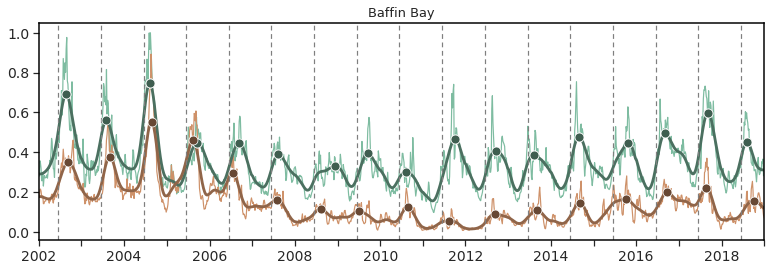

In [35]:
fig = plt.figure(figsize=(13,4))

st = sns.axes_style("ticks")

with st:
    ax = sns.lineplot(dates, BB_gc_smooth, color='#4b7060', zorder=2, linewidth=2.8)
    sns.lineplot(dates, norm_BB_gc, color='#7ebca1', zorder=1, linewidth=1.2)
    sns.scatterplot(x=[dates[int(t)] for t in time_lag_BB_gc_date if ~np.isnan(t)], \
                    y=[BB_gc_smooth[int(t)] for t in time_lag_BB_gc_date if ~np.isnan(t)], \
                    color='#3f5e50', zorder=3, s=80)
    
    sns.lineplot(dates, BB_cn_smooth, color='#906549', zorder=2, linewidth=2.8)
    sns.lineplot(dates, norm_BB_cn, color='#ce9169', zorder=1, linewidth=1.2)
    sns.scatterplot(x=[dates[int(t)] for t in time_lag_BB_cn_date if ~np.isnan(t)], \
                    y=[BB_cn_smooth[int(t)] for t in time_lag_BB_cn_date if ~np.isnan(t)], \
                    color='#674834', zorder=3, s=80)
    
    for i in cn_i:
        ax.axvline(months[i], color='#7f7f7f', linewidth=1.2, zorder=2, linestyle='--', dashes=(4, 3))
    
    ax.set_title('Baffin Bay', fontsize=13)
    plt.xticks([dt.datetime(year,1,1) for year in range(2002,2020)])
    ax.set_xticklabels(['2002', '', '2004', '', '2006', '','2008', '', '2010', '', '2012', '', '2014', \
                    '', '2016', '', '2018', ''])
    ax.set(xlim=(dt.datetime(2002,1,1), dt.datetime(2019,1,1)))
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');


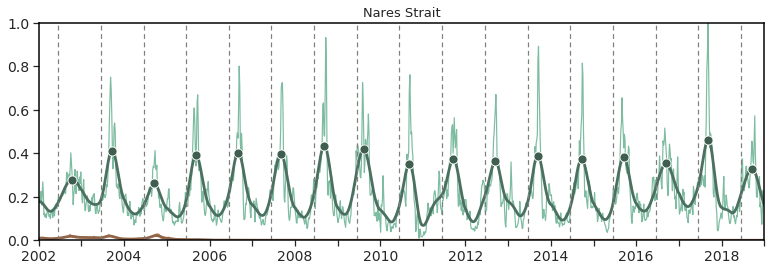

In [36]:
fig = plt.figure(figsize=(13,4))

st = sns.axes_style("ticks")

with st:
    ax = sns.lineplot(dates, N1_gc_smooth, color='#4b7060', zorder=2, linewidth=2.8)
    sns.lineplot(dates, norm_N1_gc, color='#7ebca1', zorder=1, linewidth=1.2)
    sns.scatterplot(x=[dates[int(t)] for t in time_lag_N1_gc_date if ~np.isnan(t)], \
                    y=[N1_gc_smooth[int(t)] for t in time_lag_N1_gc_date if ~np.isnan(t)], \
                    color='#3f5e50', zorder=3, s=80)
    
    sns.lineplot(dates, N1_cn_smooth, color='#906549', zorder=2, linewidth=2.8)
    sns.lineplot(dates, norm_N1_cn, color='#ce9169', zorder=1, linewidth=1.2)
    
    for i in cn_i:
        ax.axvline(months[i], color='#7f7f7f', linewidth=1.2, zorder=2, linestyle='--', dashes=(4, 3))
    
    ax.set_title('Nares Strait', fontsize=13)
    plt.xticks([dt.datetime(year,1,1) for year in range(2002,2020)])
    ax.set_xticklabels(['2002', '', '2004', '', '2006', '','2008', '', '2010', '', '2012', '', '2014', \
                    '', '2016', '', '2018', ''])
    ax.set(xlim=(dt.datetime(2002,1,1), dt.datetime(2019,1,1)), ylim=(0,1))
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');


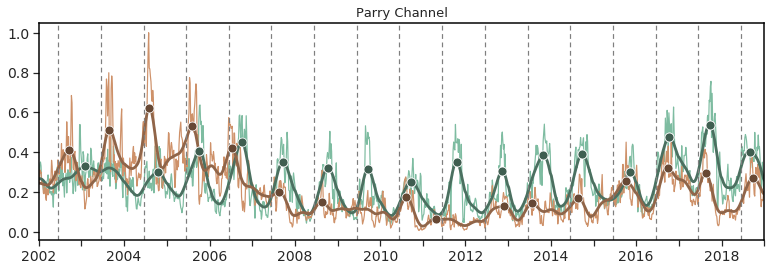

In [37]:
fig = plt.figure(figsize=(13,4))

st = sns.axes_style("ticks")

with st:
    ax = sns.lineplot(dates, PC_gc_smooth, color='#4b7060', zorder=2, linewidth=2.8)
    sns.lineplot(dates, norm_PC_gc, color='#7ebca1', zorder=1, linewidth=1.2)
    sns.scatterplot(x=[dates[int(t)] for t in time_lag_PC_gc_date if ~np.isnan(t)], \
                    y=[PC_gc_smooth[int(t)] for t in time_lag_PC_gc_date if ~np.isnan(t)], \
                    color='#3f5e50', zorder=3, s=80)
    
    sns.lineplot(dates, PC_cn_smooth, color='#906549', zorder=2, linewidth=2.8)
    sns.lineplot(dates, norm_PC_cn, color='#ce9169', zorder=1, linewidth=1.2)
    sns.scatterplot(x=[dates[int(t)] for t in time_lag_PC_cn_date if ~np.isnan(t)], \
                    y=[PC_cn_smooth[int(t)] for t in time_lag_PC_cn_date if ~np.isnan(t)], \
                    color='#674834', zorder=3, s=80)
    
    for i in cn_i:
        ax.axvline(months[i], color='#7f7f7f', linewidth=1.2, zorder=2, linestyle='--', dashes=(4, 3))
    
    ax.set_title('Parry Channel', fontsize=13)
    plt.xticks([dt.datetime(year,1,1) for year in range(2002,2020)])
    ax.set_xticklabels(['2002', '', '2004', '', '2006', '','2008', '', '2010', '', '2012', '', '2014', \
                    '', '2016', '', '2018', ''])
    ax.set(xlim=(dt.datetime(2002,1,1), dt.datetime(2019,1,1)))
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');


Remove the bad detected peaks:

In [46]:
time_lag_PC_gc[0]  = []; time_lag_PC_gc_date[0]  = [];
time_lag_PC_cn[8]  = []; time_lag_PC_cn_date[8]  = [];

time_lag_PC_gc      = list(filter(None, time_lag_PC_gc));
time_lag_PC_cn      = list(filter(None, time_lag_PC_cn));
time_lag_PC_gc_date = list(filter(None, time_lag_PC_gc_date))
time_lag_PC_cn_date = list(filter(None, time_lag_PC_cn_date))

#### Figures:

In [47]:
print('------Glacial discharge------------------------')
print('Baffin Bay: -----------------------------------')
print('Average lag time (days): ', np.nanmean(time_lag_BB_gc))
print('Maximum lag time (days): ', np.nanmax(time_lag_BB_gc))
print('Minimum lag time (days): ', np.nanmin(time_lag_BB_gc))
print('Std of lag time (days):  ', np.nanstd(time_lag_BB_gc))
print('')
print('Nares Strait: ---------------------------------')
print('Average lag time (days): ', np.nanmean(time_lag_N1_gc))
print('Maximum lag time (days): ', np.nanmax(time_lag_N1_gc))
print('Minimum lag time (days): ', np.nanmin(time_lag_N1_gc))
print('Std of lag time (days):  ', np.nanstd(time_lag_N1_gc))
print('')
print('Parry Channel: --------------------------------')
print('Average lag time (days): ', np.nanmean(time_lag_PC_gc))
print('Maximum lag time (days): ', np.nanmax(time_lag_PC_gc))
print('Minimum lag time (days): ', np.nanmin(time_lag_PC_gc))
print('Std of lag time (days):  ', np.nanstd(time_lag_PC_gc))

------Glacial discharge------------------------
Baffin Bay: -----------------------------------
Average lag time (days):  103.3030303030303
Maximum lag time (days):  191
Minimum lag time (days):  19
Std of lag time (days):   46.66936237786689

Nares Strait: ---------------------------------
Average lag time (days):  103.63636363636364
Maximum lag time (days):  161
Minimum lag time (days):  29
Std of lag time (days):   29.154570494456838

Parry Channel: --------------------------------
Average lag time (days):  104.6
Maximum lag time (days):  161.0
Minimum lag time (days):  20.0
Std of lag time (days):   30.21213884075957


In [48]:
print('------Continental discharge--------------------')
print('Baffin Bay: -----------------------------------')
print('Average lag time (days): ', np.nanmean(time_lag_BB_cn))
print('Maximum lag time (days): ', np.nanmax(time_lag_BB_cn))
print('Minimum lag time (days): ', np.nanmin(time_lag_BB_cn))
print('Std of lag time (days):  ', np.nanstd(time_lag_BB_cn))
print('')
print('Parry Channel: --------------------------------')
print('Average lag time (days): ', np.nanmean(time_lag_PC_cn))
print('Maximum lag time (days): ', np.nanmax(time_lag_PC_cn))
print('Minimum lag time (days): ', np.nanmin(time_lag_PC_cn))
print('Std of lag time (days):  ', np.nanstd(time_lag_PC_cn))

------Continental discharge--------------------
Baffin Bay: -----------------------------------
Average lag time (days):  72.05555555555556
Maximum lag time (days):  109
Minimum lag time (days):  19
Std of lag time (days):   23.341599065050794

Parry Channel: --------------------------------
Average lag time (days):  75.375
Maximum lag time (days):  164.0
Minimum lag time (days):  24.0
Std of lag time (days):   32.733535937933745


Time lag difference between continental and glacial arrival in Baffin bay:

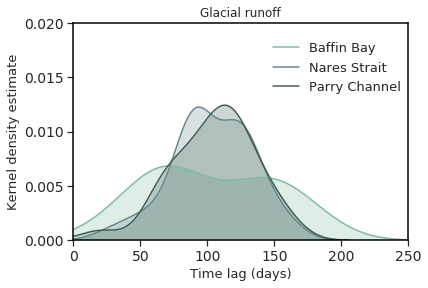

In [75]:
st = sns.axes_style("ticks")

with st:
    fig = plt.figure(figsize=(6,4))
    
    ax = sns.kdeplot(time_lag_BB_gc, shade=True, color='#7ebca1', label='Baffin Bay')

    sns.kdeplot(time_lag_N1_gc, shade=True, color='#66868c', label='Nares Strait')

    sns.kdeplot(time_lag_PC_gc, shade=True, color='#3f5e50', label='Parry Channel')

    ax.set(ylim=(0, 0.02), xlim=(0,250))
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');

    ax.set_xlabel('Time lag (days)', fontsize=13)
    ax.set_ylabel('Kernel density estimate', fontsize=13)
    ax.set_title('Glacial runoff')
    ax.legend(loc=(0.58, 0.65), fontsize=13, frameon=False)
    
fig.savefig('/ocean/brogalla/GEOTRACES/figures/rivers/R3-time-lag-gc.png', bbox_inches='tight', dpi=300)

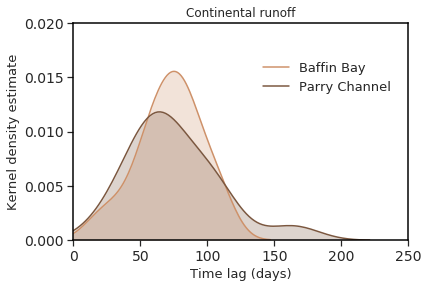

In [72]:
st = sns.axes_style("ticks")

with st:
    fig = plt.figure(figsize=(6,4))
    ax = sns.kdeplot(time_lag_BB_cn, shade=True, color='#ce9169', label='Baffin Bay')

    sns.kdeplot(time_lag_PC_cn, shade=True, color='#7b573f', label='Parry Channel')
    
    ax.set(ylim=(0, 0.02), xlim=(0,250))
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');

    ax.set_xlabel('Time lag (days)', fontsize=13)
    ax.set_ylabel('Kernel density estimate', fontsize=13)
    ax.set_title('Continental runoff')
    
    ax.legend(loc=(0.55, 0.65), fontsize=13, frameon=False)
    
fig.savefig('/ocean/brogalla/GEOTRACES/figures/rivers/R3-time-lag-cn.png', bbox_inches='tight', dpi=300)

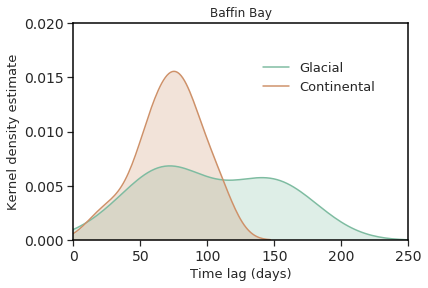

In [73]:
st = sns.axes_style("ticks")

with st:
    fig = plt.figure(figsize=(6,4))
    ax = sns.kdeplot(time_lag_BB_gc, shade=True, color='#7ebca1', label='Glacial')
    sns.kdeplot(time_lag_BB_cn, shade=True, color='#ce9169', label='Continental')
    
    ax.set(ylim=(0, 0.02), xlim=(0,250))
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');

    ax.set_xlabel('Time lag (days)', fontsize=13)
    ax.set_ylabel('Kernel density estimate', fontsize=13)
    ax.set_title('Baffin Bay')
    
    ax.legend(loc=(0.55, 0.65), fontsize=13, frameon=False)
    
fig.savefig('/ocean/brogalla/GEOTRACES/figures/rivers/R3-time-lag-BB.png', bbox_inches='tight', dpi=300)

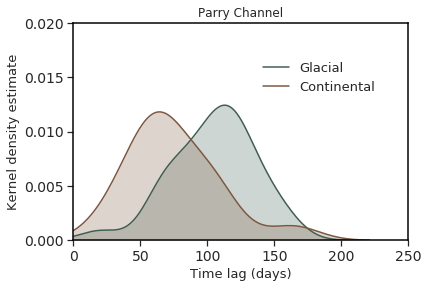

In [74]:
st = sns.axes_style("ticks")

with st:
    fig = plt.figure(figsize=(6,4))
    ax = sns.kdeplot(time_lag_PC_gc, shade=True, color='#3f5e50', label='Glacial')
    sns.kdeplot(time_lag_PC_cn, shade=True, color='#7b573f', label='Continental')
    
    ax.set(ylim=(0, 0.02), xlim=(0,250))
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');

    ax.set_xlabel('Time lag (days)', fontsize=13)
    ax.set_ylabel('Kernel density estimate', fontsize=13)
    ax.set_title('Parry Channel')
    
    ax.legend(loc=(0.55, 0.65), fontsize=13, frameon=False)
    
fig.savefig('/ocean/brogalla/GEOTRACES/figures/rivers/R3-time-lag-PC.png', bbox_inches='tight', dpi=300)